In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Advecting the density in 2D using front tracking

Instead of advecting the density directly, we can move the interface between the different fluids and reconstruct the density from its location. This is usually called "front tracking". Here we describe a very simple implementation of front tracking and show how to modify the code introduced in the last chaped to update the density in that way. Unlike when we advect the desntiy directly, using front tracking is a two step process: We move the boundary and then we construct the density field. In some cases we define an indecator function that is used to set the desnity and other material properties, but here we use the density as the indicator function.

First, however, we have to decide how we represent the iterface. Generally the interfaces must be dynamically reconstructed by added and deleting points as the interface deforms. In three dimension the correct data structure can be critical for the successful implementation of the method. For two-dimensional flow, on the other hand, essentially any dada structure can be made to work rather easily. Here we will use a simple ordered array of points where we represent the interface by markers who coordinates are given by:

$$ x_f(l) = (x(l), y(l)), l=1,....,N_f $$

Since the points are ordered so that point l comes after point l-1 and before point l+1, no additional information about their connectivitiy is needed. this makes it particularly simple to compute, for example, the distance between two points

$$ \Delta_{sl,l-1} = \sqrt{(x(l)-x(l-1))^2 + (y(l)-y(l-1))^2} $$

In the coded we will carry two extra points that are identical to the first and the second point so that $x(N_f+1) = x(1)$ and $ x(N_f+2) = x(1)$ and so on. We will work with the points $l=2 \rightarrow N_f + 1$ and use the points $1$ and $N_f+2$ as ghost points to simplify operations on the front

First, lets set up the domain as we have done so before...

In [3]:

# Domain and physical variables
Lx = 1.0
Ly = 1.0
gx = 0
gy = -100
rho1 = 1.0
rho2 = 2.0
m0 = 0.01
rro = rho1
unorth = 0
usouth = 0
veast = 0
vwest = 0
time = 0.0

# Initial drop size and location
rad = 0.15
xc = 0.5
yc = 0.5

# Numerical variables
nx = 32
ny = 32
dt = 0.005
nstep = 300
maxit = 200
maxError = 0.002
beta = 1.2

# Zero arrays
u = np.zeros((nx+1, ny+2))
v = np.zeros((nx+2, ny+1))
p = np.zeros((nx+2, ny+2))
ut = np.zeros((nx+1, ny+2))
vt = np.zeros((nx+2, ny+1))
tmp1 = np.zeros((nx+2, ny+2))
uu = np.zeros((nx+1, ny+1))
vv = np.zeros((nx+1, ny+1))
tmp2 = np.zeros((nx+2, ny+2))

# Create the grid
dx = Lx/nx
dy = Ly/ny
x = np.zeros(nx+2)
y = np.zeros(ny+2)

for i in range(len(x)):
    x[i] = dx*(i-0.5)

for j in range(len(y)):
    y[j] = dy*(j-0.5)

XX, YY = np.meshgrid(x, y)

in_circle = (XX-xc)**2 + (YY-yc)**2 < rad**2

r = np.zeros((len(x), len(y))) + rho1
r[in_circle] = rho2

In [4]:
def makegraph(x,y,u,v,nx,ny,dx,dy,r,steps, plot_quiver=False):
    fig = plt.figure(figsize=(3,3), dpi=150)
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
    yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
    plt.contourf(x,y,r.T,5)
    plt.colorbar
    if plot_quiver:
        plt.quiver(xx,yy,uu.T,vv.T)
    plt.title('Time Step %s' %(steps))

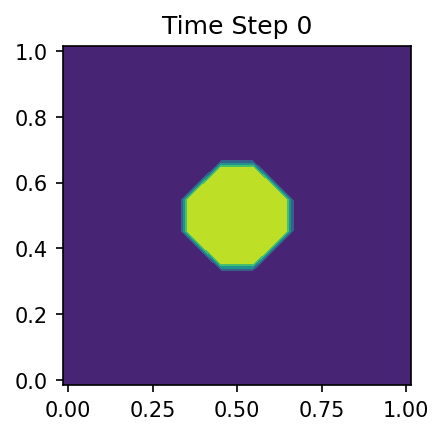

In [5]:
makegraph(x,y,u,v,nx,ny,dx,dy,r,0)

Now lets set up the front

In [6]:
def create_front_points(Nf=100):
    xf = np.zeros(Nf+2)
    yf = np.zeros(Nf+2)
    for i in range(Nf+1):
        xf[i] = xc - rad*np.sin(2.0*np.pi*i/Nf)
        yf[i] = yc + rad*np.cos(2.0*np.pi*i/Nf)
    return xf, yf

Nf = 100
xf, yf = create_front_points(Nf)

Now lets modify the plotting function to show the front

In [13]:
def makegraph(x,y,u,v,nx,ny,dx,dy,xf,yf,Nf,r,steps,plot_quiver=False):
    fig = plt.figure(figsize=(3,3), dpi=150)
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
    yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
    plt.contourf(x,y,r.T,5)
    plt.colorbar
    if plot_quiver:
        plt.quiver(xx,yy,uu.T,vv.T)
    plt.plot(xf[0:Nf+1], yf[0:Nf+1],linewidth=5.0) # New line
    plt.title('Time Step %s' %(steps))

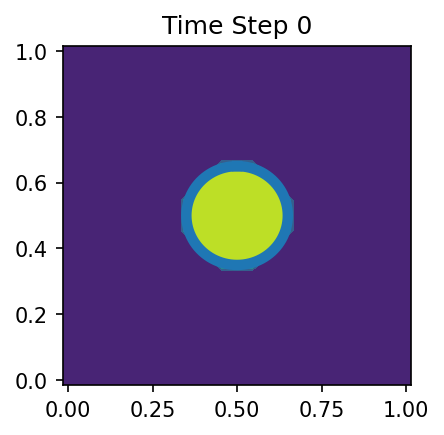

In [8]:
makegraph(x, y, u, v, nx, ny, dx, dy, xf, yf, Nf, r, 0)

## Moving the front

To move the marker points we interpolate their velocitues from the velocity field given on the fixed fluid grid. Similarly, quantities such as the density jump and the surface tension are smoothed from the front onto the fixed grid. The interpolation and smoothing can be done in different ways but here we will use a bilinear interpolation and once we have determined he weights, we will use the same ones for the smoothing. Before communication between the front and the fixed grid, we need to identify the fixed grid points closes to a given point on the front. For a rectangular domain of length $L_x$, devided into $N_x$ equal sized control volumes, with the grid point where $i=1$ corresponding to $x=0$, the grid point on the left of the front point $x_f$ is given by:

$$ i = FLOOR(x_f(l)/ \Delta x)+1$$

Where FLOOR stands for an operation rounding its operand down to its closes interger value. While this expression holds for the u-velocities on the grid, it must be modified for the v-velocities where the grid is splaced half a grid spacing to the left. Then we must use

$$ i = FLOOR((x_f(l)+0.5\Delta x)/\Delta x) + 1 $$

For the j-direction, we swap those.

These expresssions are also used when we smooth front quantities onto the velocity. Notice that while is is trivial to find which fixed grid points are close to a given fixed point, the reverse problem is much harder. Usually it is possible to arrange the code in such a way that we need to find a fixed grid points close to a given front point, rather than the other way around.

After the fixed grid points that are closes to a given location on the front have been located, we can interpolate values in the grid to the front. If we use a bilinear interpolation, then the front value $\phi^l_f$ is given by:

<img src ="https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Bilinear_interpolation_visualisation.svg/800px-Bilinear_interpolation_visualisation.svg.png" width=300/>

$$\phi^l_f =    \phi_{i,j}\left( \frac{x_{i+1}-x_f}{\Delta x} \right)\left(\frac{y_{j+1}-y_f}{\Delta y}\right) +
                \phi_{i,j+1}\left( \frac{x_{i+1}-x_f}{\Delta x} \right)\left(\frac{y_f-y_j}{\Delta y}\right) +
                \phi_{i+1,j}\left( \frac{x_f-x_{i}}{\Delta x} \right)\left(\frac{y_{j+1}-y_f}{\Delta y}\right) +
                \phi_{i+1,j+1}\left( \frac{x_f-x_{i}}{\Delta x} \right)\left(\frac{y_f-y_j}{\Delta y}\right) $$

Here $x_i$ is the x-coordinate of the vertical grid line to the left of the front point and $y_j$ is the y-coordinate of the horizontal grid line below the front point, both found using the above equation. $\phi_{i,j}$ is the value of $\phi$ at the gixed grid point to the left and below the front point. The weights can be interpreted as the area fractions. Bilinear interpolation is therefore often refered to as the area-weighting.

With the coefficients in the equation interpreted as weights, we can rewrite it as

$$\phi^l_f = w^l_{i,j}\phi_{i,j} + w^l_{i,j+1}\phi_{i,j+1} + w^l_{i+1,j}\phi_{i+1,j} + w^l_{i+1,j+1}\phi_{i+1,j+1}$$

Or in general,

$$ \phi^l_f = \sum_{ij}{w^l_{i,j} \phi_{i,j}}$$

where 

$$ \sum_{ij}{w^l_{i,j}} = 1 $$

For the velocity, we apply the bilinear interpolation function to each velocity component. For staggered grids, as we are using here, usually we interpolate each component separately since they are given on different fixed grids. Once the the velocity of the front $u^n_f$ has been interpolated from the grid, the front can be moved. If we use a simple explicit first-order time integration, then the new front location is given by

$$ x^{n+1}_f = x^n_f + \Delta t u^n_f $$

## Constructing the density field

To find the density, given the location of the interface, we use the fact that the front marks the jump in density. In terms of a heaviside function defined by

$$H = \begin{cases}
  1\textrm{    fluid 1}\\    
  2\textrm{    fluid 2}    
\end{cases}$$

The density can be written as

$$ \rho = \rho_1 H + (1-H) \rho_2 $$

On the fixed grid the sharp jump is translated into a steep gradient. The gradient of the density can be related to the jump by writing it as:

$$ \nabla \rho = (\rho_1 - \rho_2)\nabla H = \Delta\rho n \delta(n) $$

Where $\nabla \rho = (\rho_1-\rho_2)$ is the jump in the value of the density across the interface (usually a constant for each interface) and we have used that $\nabla H = \delta(n)\mathbf{n}$. Here $\mathbf{n}$ is a coordinate normal to the interface. Since the front represents a $\delta$-function, the transfer corresponds to the contruction of an approximation to this $\delta$-function on the fixed grid. This smoothing
can be done in several different ways, but in many cases the transferred quantity is conserved and it is important to preserve the integrated value when moving from the front to the fixed grid. The interface quantity $\phi_f$ is usually expressed in a value per unit area (or length in two dimensions) but the grid value $\phi_{i,j}$ should be given in terms of value per unit volume.

<img src="smoothing_interface_quantitites.png"/>

While this is realtively obvious for quantities such as the surface force, it is true for the density gradient as well. This can be seen in the following way: Consider the domain sketeched above and integrate over the domain containing the interface. By the divergence theorem we can rewrite the integral as an integral over the boundary

$$\int_v{\nabla pdv} = \oint_s{\rho\mathbf{n}ds}$$

The contour S can be written as a sum of three parts, one enclosing $\rho_1$, another enslosing $\rho_2$ and a third enslosing the interface, or $S = S_1 + S_2 + S_3$. Thus

$$\int_v{\rho ds} = \rho_1 \oint_{s_1}{\mathbf{n}ds} + \rho_2\oint_{s_2}{\mathbf{n}ds} + \oint_{s_l}{\rho ds}$$

The first two integrals are zero, since $\oint{\mathbf{n}ds}=$ and the last integral is

$$\oint_{s_l}{\rho ds} = \int_{-s_l}{\rho_1\mathbf{n}ds} + \int_{s1}{\rho_2\mathbf{n}ds}=\int{(\rho_1 - \rho_2)\mathbf{n}ds}$$

Therefore

$$\int_V{\nabla\rho dv} = \int_{S_I}{\Delta\rho\mathbf{n}ds}$$

where $\Delta\rho = \rho_1 - \rho_2$

This can be generalied for any conserved variable $\rho$ and to ensure that the total value is conserved in the smoothing, we must require that:

$$\int_{\Delta_v}{\phi_{i,j}(x)dv} = \int_{\Delta_s}{\phi_f(s)ds}$$

Where $\Delta s$ is the area (length in two dimensions) of the interface that is smoothed to volume $\Delta v$ (area in two dimensions). For two-dimensionsal flow, the discrete form of the grid value is therefore given by

$$ \phi_{i,j} = \sum_l{\phi^l_f w^l_{i,j}\frac{\Delta s_l}{\Delta x \Delta y}} $$

Where $\Delta s_l$ is the area of element $l$ and $\Delta x$ and $\Delta y$ are the grid spacings. Here we will use the same weights, $w^l_{i,j}$ for the smoothing as used for the interpolation.

<img src="density field.png"/>

We can, at least in principle, integrate the desnity gradient directly from a point where the density is known. If we distribute the gradient onto a staggered grid, the x-gradient is avaliable at points $(i-1/2,j)$ and so on and if the desnity at $(i-1,j)$ is known, then

$$\rho_{i,j} = \rho_{i-1,j} + \Delta x\left(\frac{\partial\rho}{\partial x}\right)_{i-1/2,j}$$

By repeated application of this equation, we can construct the density value everywhere, provided we start at a point where the density field is know. Although this operation only has to be performed at points near the front, since the density away from the front has not changed we need to find a point from which to integreate. The density field can also depend slightly on the direction in which the integration is done and errors can accumulate if we integrate over several grid points, so that the value of the density on the other side of the interface may not be correct.

To get a more symmetric expression for the density at $(i,j)$ we can integrate the density gradient from the other three grid points $(i+1,j), (i,j+1)$ and $(i,j-1)$ and average the results. The results can be rearranged to obtain

$$\rho_{i,j} = 0.25\Bigg\{\rho_{i-1,j}+\rho_{i+1,j}+\rho_{i,j-1}+\rho_{i,j+1}+\Delta x \left(\left(\frac{\partial \rho}{\partial x}\right)_{i-1/2,j} - \left(\frac{\partial \rho}{\partial x}\right)_{i+1/2,j}\right) + \Delta y \left(\left(\frac{\partial \rho}{\partial y}\right)_{i,j-1/2} - \left(\frac{\partial \rho}{\partial y}\right)_{i,j+1/2}\right)\Bigg\}$$

Which can be iterated to solve for $\rho_{i,j}$. This iteration can be accelerated using SOR or more advanced iterative techniques. In the code presented here, we update the density at every point in the domain, but in more advanced codes we can limit the updating to the vicinity of the interface. Iterating over the entire domain can generally spread out the error, so we can end up with errors in the density away from the interface, if we stop before obtaining full convergenece. Thus, limiting the iterations to only the points close to the interface is generally much more efficient.

One might be tempted to ask, why the rather elaborate approach to construct the density from the front location? Would it not be simpler to simply run over the front and set the density at the fixed grid points as a function of the minimum distance from the front? The answer is primarily that the present approach allows us to automatically deal with situations where two interfaces occupy the same grid cell. By working with the gradients, which cancel on the fixed grid, the ambiguity of setting the value of a grid point next to a double interface disappears.

## Reconstructing the front

Since the velocity of front points varies, generally the distance between front points will change as they move. They can, in particular, move sufficiently far apart so that the front is no longer well resolved. The points can also move close together and it is usually useful to delete points that crowd together, although it is not as important as adding points.

For an interface in a two-dimensional flow, consisting of ordered points, adding and deleting points is straightforward. We start by copying the front information (the coordinates of the points) into a temparty array $X_{old}$ and then copy the points back into the original array one by one, checking the distance between the point we are copying and the last point that we copied. If the distance between the points is too large, we create a new point half way between the two and put it where the next point should go. Once that is done, we copy our point into the next empty location of the original array. If the distance is less han a prescribed minimum, we do not copy the array and we move into the next point. If the distance is above the minimum distance and below the maximum distance, we copy the point directly into the new array. In this approach, the number of front points will generally change, depending on how many points we add or delete. In order to close the front, we set the location of the last point equal to the first one.

In the sample code, we use linear interpolation to find the location of the new point, when we need to add one. Generally, it is better to use a higher order interpolation, particularly when surface tension is included. When the front is represented by an unstructured grid - as are needed for three-dimensional flows - a more elaborate approach is generally necessary.

The most obvious place to restructure the front is right after we have moved it and before we distribute the gradients. For the second order order code, however, we take two steps then average the results. We can only restructure the front once per timestep and thus we will move it to a different place.

In [14]:
def solvewall():
    #===============SETUP THE COMPUTATIONAL DOMAIN==================#
    
    #Set the grid
    dx=Lx/nx; dy=Ly/ny
    x=np.linspace(-dx/2,(nx+0.5)*dx,nx+2)
    y=np.linspace(-dy/2,(ny+0.5)*dy,ny+2)

    #Set density in domain and drop:
    r=np.ones((nx+2,ny+2))*rho1
    for i in range(1,nx+1):
        for j in range (1,ny+1):
            if ((x[i]-xc)**2+(y[j]-yc)**2)<rad**2:
                r[i,j]=rho2;

    #Zero arrays
    u=np.zeros((nx+1,ny+2)); v=np.zeros((nx+2,ny+1)); p=np.zeros((nx+2,ny+2))
    ut=np.zeros((nx+1,ny+2)); vt=np.zeros((nx+2,ny+1)); tmp1=np.zeros((nx+2,ny+2));
    uu=np.zeros((nx+1,ny+1)); vv=np.zeros((nx+1,ny+1)); tmp2=np.zeros((nx+2,ny+2))
    
    #================SETUP THE FRONT=====================#
    Nf=100;
    xf=np.zeros((Nf+2)); yf=np.zeros((Nf+2))
    for i in range(Nf+1):
        xf[i]=xc-rad*np.sin(2.0*np.pi*i/Nf);
        yf[i]=yc+rad*np.cos(2.0*np.pi*i/Nf);
    
    #fig = plt.figure(figsize=(15,22.5), dpi=300)
    plotcount=0
        
    #===============START THE TIME LOOP==================#
    
    for steps in range (nstep):
        fx=np.zeros((nx+2,ny+2)); fy=np.zeros((nx+2,ny+2))

        #Tangential at boundaries: (Dieter's code is not correct at the part u[:,-1])
        u[:,0]=2*usouth-u[:,1];u[:,nx+1]=2*unorth-u[:,ny];
        v[0,:]=2*vwest-v[1,:];v[ny+1,:]=2*veast-v[nx,:];

        #Temporary u-velocity
        ut[1:-1,1:-1]=u[1:-1,1:-1]+dt*(-0.25*(((u[2:,1:-1]+u[1:-1,1:-1])**2-(u[1:-1,1:-1]+u[0:-2,1:-1])**2)/dx+\
                                              ((u[1:-1,2:]+u[1:-1,1:-1])*(v[2:-1,1:]+v[1:-2,1:])-\
                                               (u[1:-1,1:-1]+u[1:-1,0:-2])*(v[2:-1,0:-1]+v[1:-2,0:-1]))/dy)+\
                                       m0/(0.5*(r[2:-1,1:-1]+r[1:-2,1:-1]))*\
                                       ((u[2:,1:-1]-2*u[1:-1,1:-1]+u[0:-2,1:-1])/(dx**2)+\
                                        (u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,0:-2])/(dy**2))+gx)

        #Temporary v-velocity
        vt[1:-1,1:-1]=v[1:-1,1:-1]+dt*(-0.25*(((u[1:,2:-1]+u[1:,1:-2])*(v[2:,1:-1]+v[1:-1,1:-1])-\
                                               (u[0:-1,2:-1]+u[0:-1,1:-2])*(v[1:-1,1:-1]+v[0:-2,1:-1]))/dx+\
                                              ((v[1:-1,2:]+v[1:-1,1:-1])**2-(v[1:-1,1:-1]+v[1:-1,0:-2])**2)/dy)+\
                                       m0/(0.5*(r[1:-1,2:-1]+r[1:-1,1:-2]))*\
                                       ((v[2:,1:-1]-2*v[1:-1,1:-1]+v[0:-2,1:-1])/(dx**2)+\
                                        (v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,0:-2])/(dy**2))+gy)

        # Coefficient for p(i,j):
        rt=r.copy(); lrg=1000;
        rt[:,0]=lrg; rt[:,ny+1]=lrg;
        rt[0,:]=lrg; rt[nx+1,:]=lrg;

        tmp1[1:-1,1:-1]=(0.5/dt)*((ut[1:,1:-1]-ut[0:-1,1:-1])/dx+(vt[1:-1,1:]-vt[1:-1,0:-1])/dy)
        tmp2[1:-1,1:-1]=1.0/((1./dx)*(1./(dx*(rt[2:,1:-1]+rt[1:-1,1:-1]))+\
                                      1./(dx*(rt[0:-2,1:-1]+rt[1:-1,1:-1])))+\
                             (1./dy)*(1./(dy*(rt[1:-1,2:]+rt[1:-1,1:-1]))+\
                                     1./(dy*(rt[1:-1,0:-2]+rt[1:-1,1:-1]))))

        # Poisson solver for p:
        iter=0
        while True:
            pn=p.copy()
            iter=iter+1
            for i in range(1,nx+1):
                for j in range(1,ny+1):
                    p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                        (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                        p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                        (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                        p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])

            if np.abs(pn-p).max()<maxError:
                break
            if iter>maxiter:
                break

        #Calculate u-velocity:
        u[1:-1,1:-1]=ut[1:-1,1:-1]-dt*(2.0/dx)*(p[2:-1,1:-1]-p[1:-2,1:-1])/(r[2:-1,1:-1]+r[1:-2,1:-1])


        #Calculate v-velocity:
        v[1:-1,1:-1]=vt[1:-1,1:-1]-dt*(2.0/dy)*(p[1:-1,2:-1]-p[1:-1,1:-2])/(r[1:-1,2:-1]+r[1:-1,1:-2])


        #===============FRONT TRACKING AND DENSITY DISTRIBUTION==================#
        
        #Calculate front velocity:
        uf=np.zeros((Nf+2)); vf=np.zeros((Nf+2))

        for i in range (1,Nf+1):

            #Calculate x-component
            ip=int(np.floor(xf[i]/dx)); jp=int(np.floor((yf[i]+0.5*dy)/dy));
            ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
            uf[i]=(1.0-ax)*(1.0-ay)*u[ip,jp]+ax*(1.0-ay)*u[ip+1,jp]+(1.0-ax)*ay*u[ip,jp+1]+ax*ay*u[ip+1,jp+1]

            #Calculate y-component
            ip=int(np.floor((xf[i]+0.5*dx)/dx)); jp=int(np.floor(yf[i]/dy))
            ax=(xf[i]+0.5*dx)/dx-ip;ay=yf[i]/dy-jp
            vf[i]=(1.0-ax)*(1.0-ay)*v[ip,jp]+ax*(1.0-ay)*v[ip+1,jp]+(1.0-ax)*ay*v[ip,jp+1]+ax*ay*v[ip+1,jp+1]

        #Move the front:
        for i in range (1,Nf+1):
            xf[i]=xf[i]+uf[i]*dt;yf[i]=yf[i]+vf[i]*dt

        xf[0]=xf[Nf]; yf[0]=yf[Nf]; xf[Nf+1]=xf[1]; yf[Nf+1]=yf[1]

        # Add points to the front
        xfold=xf.copy(); yfold=yf.copy(); j=0;
        xf1=[]; xf1.append(xf[0]);
        yf1=[]; yf1.append(yf[0]);
        for i in range (1,Nf+1):
            ds=np.sqrt(((xfold[i]-xf1[j])/dx)**2+((yfold[i]-yf1[j])/dy)**2);
            if ds>0.5:
                j=j+1;xf1.append(0.5*(xfold[i]+xf1[j-1]));yf1.append(0.5*(yfold[i]+yf1[j-1]))
                j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])
            elif ds>0.25:
                j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])

        Nf=j-1; xf=np.asarray(xf1);yf=np.asarray(yf1)
        xf[0]=xf[Nf];yf[0]=yf[Nf]
        xf[Nf+1]=xf[1];yf[Nf+1]=yf[1]

        #Distribute gradient:
        fx=np.zeros((nx+2,nx+2)); fy=np.zeros((nx+2,ny+2))
        for i in range (1,Nf+1):
            nfx=-0.5*(yf[i+1]-yf[i-1])*(rho2-rho1)
            nfy=0.5*(xf[i+1]-xf[i-1])*(rho2-rho1)

            ip=int(np.floor(xf[i]/dx)); jp=int(np.floor((yf[i]+0.5*dy)/dy));
            ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
            fx[ip,jp] =fx[ip,jp]+(1.0-ax)*(1.0-ay)*nfx/dx/dy;
            fx[ip+1,jp] =fx[ip+1,jp]+ax*(1.0-ay)*nfx/dx/dy;
            fx[ip,jp+1] =fx[ip,jp+1]+(1.0-ax)*ay*nfx/dx/dy;
            fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/dx/dy;

            ip=int(np.floor((xf[i]+0.5*dx)/dx)); jp=int(np.floor(yf[i]/dy));
            ax=(xf[i]+0.5*dx)/dx-ip; ay=yf[i]/dy-jp;
            fy[ip,jp] =fy[ip,jp]+(1.0-ax)*(1.0-ay)*nfy/dx/dy;
            fy[ip+1,jp] =fy[ip+1,jp]+ax*(1.0-ay)*nfy/dx/dy;
            fy[ip,jp+1] =fy[ip,jp+1]+(1.0-ax)*ay*nfy/dx/dy;
            fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/dx/dy;

        #Construct the density
        iter=0
        while True:
            rt=r.copy()
            iter=iter+1
            r[1:-1,1:-1]=0.25*(r[2:,1:-1]+r[0:-2,1:-1]+r[1:-1,2:]+r[1:-1,0:-2]+
                              dx*(fx[0:-2,1:-1]-fx[1:-1,1:-1])+ dy*(fy[1:-1,0:-2]-fy[1:-1,2:]))
            if np.abs(rt-r).max()<maxError:
                break
            if iter>maxiter:
                break
        
        #===============PLOTTING==================#
        if (steps >= nstep/10*(plotcount) and steps < nstep/10*(plotcount)+1) or steps==nstep-1:
            makegraph(x,y,u,v,nx,ny,dx,dy,xf,yf,Nf,r,steps)
            plotcount=plotcount+1
        
        plt.show()
        

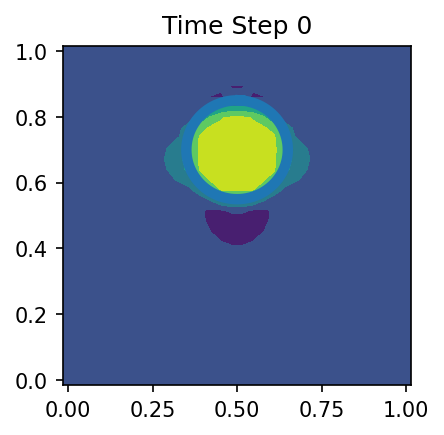

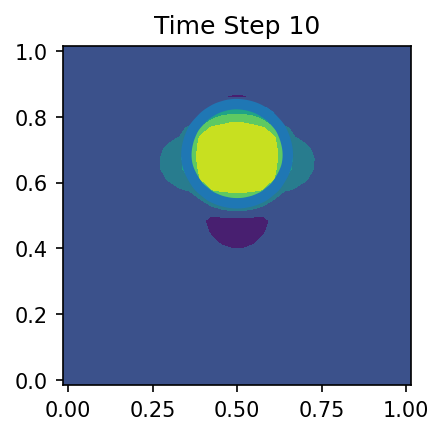

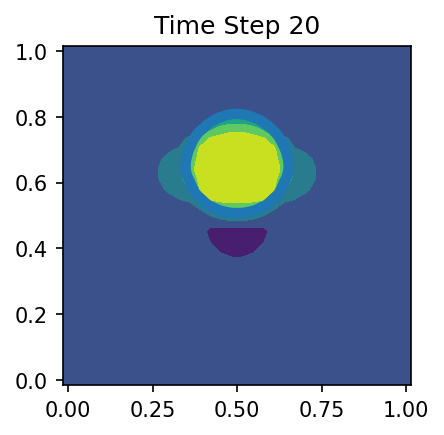

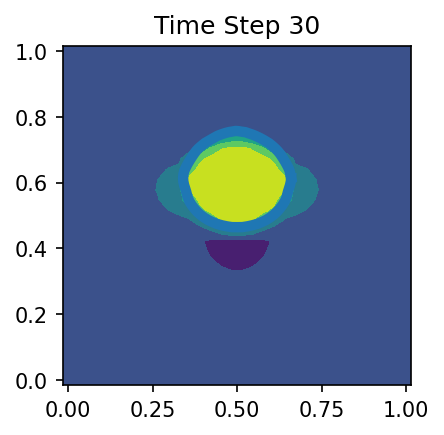

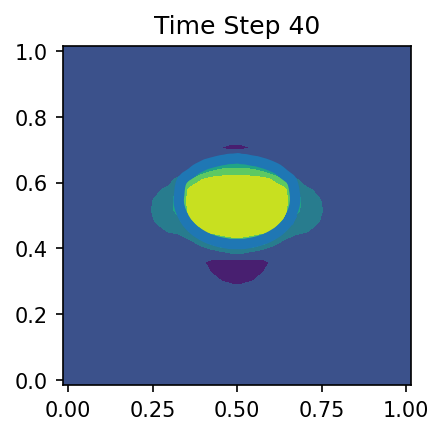

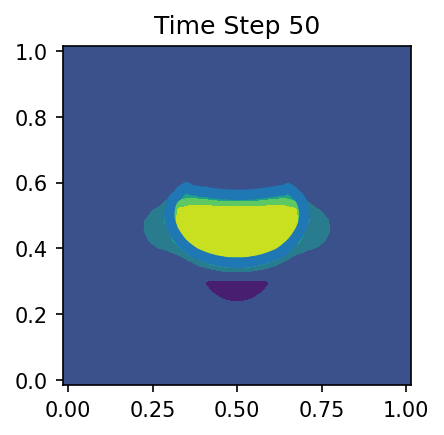

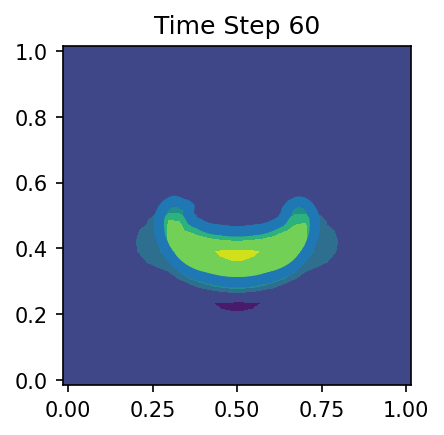

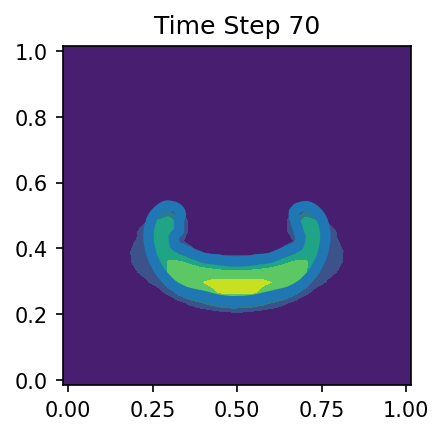

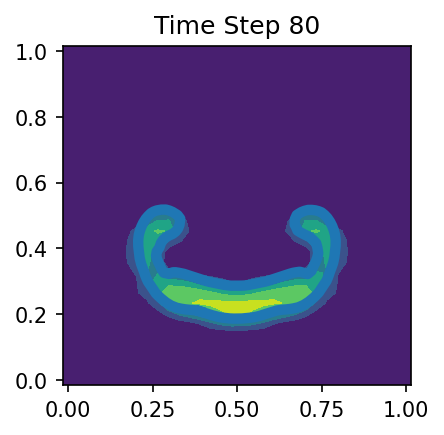

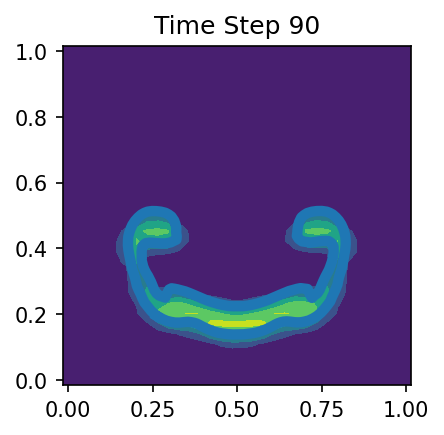

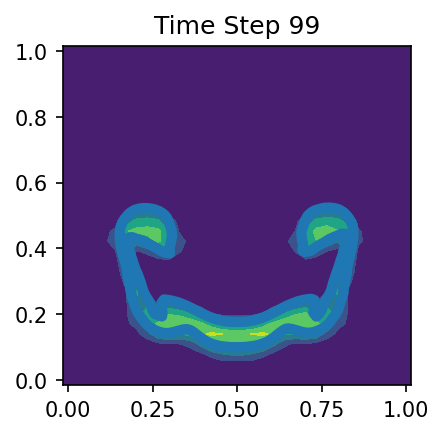

In [15]:

#Domain size and constant parameters
Lx=1.0; Ly=1.0
gx=0.0; gy=-100.0;
rho1=1.0; rho2=2.0
m0=0.01;
rro=rho1;


#Velocity at wall boundary
unorth=0; usouth=0; veast=0; vwest=0; 

#Initial drop size and location
time=0.0; rad=0.15; xc=0.5; yc=0.7;

#Numerical variables
nx=32; ny=32;
dt=0.0025; nstep=100
maxiter=200; maxError=0.001
beta=1.2;

solvewall()

Lets make this code a bit better.

hi


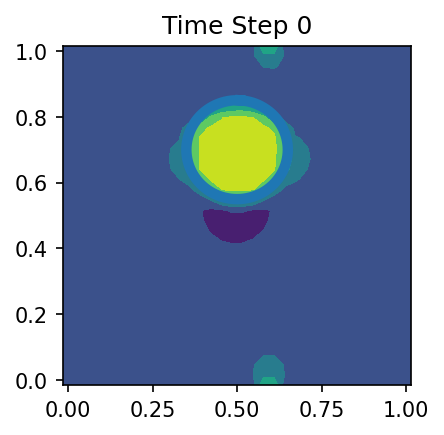

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


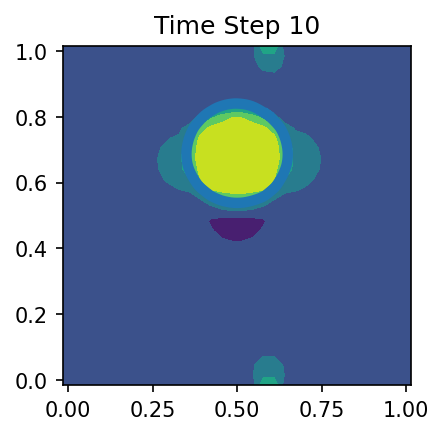

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


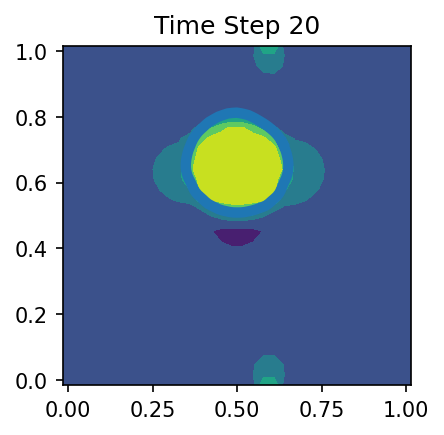

hi
hi
hi


KeyboardInterrupt: 

In [43]:
def solvewall2():
    #===============SETUP THE COMPUTATIONAL DOMAIN==================#
    
    #Set the grid
    dx=Lx/nx; dy=Ly/ny
    x=np.linspace(-dx/2,(nx+0.5)*dx,nx+2)
    y=np.linspace(-dy/2,(ny+0.5)*dy,ny+2)

    #Set density in domain and drop:
    r=np.ones((nx+2,ny+2))*rho1
    dist = ((x-xc)**2+(y-yc)**2)
    r[dist<rad**2] = rho2

    #Zero arrays
    u=np.zeros((nx+1,ny+2)); v=np.zeros((nx+2,ny+1)); p=np.zeros((nx+2,ny+2))
    ut=np.zeros((nx+1,ny+2)); vt=np.zeros((nx+2,ny+1)); tmp1=np.zeros((nx+2,ny+2));
    uu=np.zeros((nx+1,ny+1)); vv=np.zeros((nx+1,ny+1)); tmp2=np.zeros((nx+2,ny+2))
    
    #================SETUP THE FRONT=====================#
    Nf=100;
    xf=np.zeros((Nf+2)); yf=np.zeros((Nf+2))
    i = np.arange(Nf+1)
    xf[i] = xc-rad*np.sin(2.0*np.pi*i/Nf);
    yf[i] = yc+rad*np.cos(2.0*np.pi*i/Nf);
    #for i in range(Nf+1):
    #    xf[i]=xc-rad*np.sin(2.0*np.pi*i/Nf);
    #    yf[i]=yc+rad*np.cos(2.0*np.pi*i/Nf);
    
    #fig = plt.figure(figsize=(15,22.5), dpi=300)
    plotcount=0

    #===============START THE TIME LOOP==================#
    
    for steps in range (nstep):
        print("hi")
        fx=np.zeros((nx+2,ny+2)); fy=np.zeros((nx+2,ny+2))

        #Tangential at boundaries: (Dieter's code is not correct at the part u[:,-1])
        u[:,0]=2*usouth-u[:,1];u[:,nx+1]=2*unorth-u[:,ny];
        v[0,:]=2*vwest-v[1,:];v[ny+1,:]=2*veast-v[nx,:];

        #Temporary u-velocity
        ut[1:-1,1:-1]=u[1:-1,1:-1]+dt*(-0.25*(((u[2:,1:-1]+u[1:-1,1:-1])**2-(u[1:-1,1:-1]+u[0:-2,1:-1])**2)/dx+\
                                              ((u[1:-1,2:]+u[1:-1,1:-1])*(v[2:-1,1:]+v[1:-2,1:])-\
                                               (u[1:-1,1:-1]+u[1:-1,0:-2])*(v[2:-1,0:-1]+v[1:-2,0:-1]))/dy)+\
                                       m0/(0.5*(r[2:-1,1:-1]+r[1:-2,1:-1]))*\
                                       ((u[2:,1:-1]-2*u[1:-1,1:-1]+u[0:-2,1:-1])/(dx**2)+\
                                        (u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,0:-2])/(dy**2))+gx)

        #Temporary v-velocity
        vt[1:-1,1:-1]=v[1:-1,1:-1]+dt*(-0.25*(((u[1:,2:-1]+u[1:,1:-2])*(v[2:,1:-1]+v[1:-1,1:-1])-\
                                               (u[0:-1,2:-1]+u[0:-1,1:-2])*(v[1:-1,1:-1]+v[0:-2,1:-1]))/dx+\
                                              ((v[1:-1,2:]+v[1:-1,1:-1])**2-(v[1:-1,1:-1]+v[1:-1,0:-2])**2)/dy)+\
                                       m0/(0.5*(r[1:-1,2:-1]+r[1:-1,1:-2]))*\
                                       ((v[2:,1:-1]-2*v[1:-1,1:-1]+v[0:-2,1:-1])/(dx**2)+\
                                        (v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,0:-2])/(dy**2))+gy)

        # Coefficient for p(i,j):
        rt=r.copy(); lrg=1000;
        rt[:,0]=lrg; rt[:,ny+1]=lrg;
        rt[0,:]=lrg; rt[nx+1,:]=lrg;

        tmp1[1:-1,1:-1]=(0.5/dt)*((ut[1:,1:-1]-ut[0:-1,1:-1])/dx+(vt[1:-1,1:]-vt[1:-1,0:-1])/dy)
        tmp2[1:-1,1:-1]=1.0/((1./dx)*(1./(dx*(rt[2:,1:-1]+rt[1:-1,1:-1]))+\
                                      1./(dx*(rt[0:-2,1:-1]+rt[1:-1,1:-1])))+\
                             (1./dy)*(1./(dy*(rt[1:-1,2:]+rt[1:-1,1:-1]))+\
                                     1./(dy*(rt[1:-1,0:-2]+rt[1:-1,1:-1]))))

        # Poisson solver for p:
        iter=0
        while True:
            pn=p.copy()
            iter=iter+1
            for i in range(1,nx+1):
                for j in range(1,ny+1):
                    p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                        (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                        p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                        (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                        p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])

            if np.abs(pn-p).max()<maxError:
                break
            if iter>maxiter:
                break

        #Calculate u-velocity:
        u[1:-1,1:-1]=ut[1:-1,1:-1]-dt*(2.0/dx)*(p[2:-1,1:-1]-p[1:-2,1:-1])/(r[2:-1,1:-1]+r[1:-2,1:-1])


        #Calculate v-velocity:
        v[1:-1,1:-1]=vt[1:-1,1:-1]-dt*(2.0/dy)*(p[1:-1,2:-1]-p[1:-1,1:-2])/(r[1:-1,2:-1]+r[1:-1,1:-2])


        #===============FRONT TRACKING AND DENSITY DISTRIBUTION==================#
        
        #Calculate front velocity:
        uf=np.zeros((Nf+2)); vf=np.zeros((Nf+2))

        for i in range (1,Nf+1):

            #Calculate x-component
            ip=int(np.floor(xf[i]/dx)); jp=int(np.floor((yf[i]+0.5*dy)/dy));
            ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
            uf[i]=(1.0-ax)*(1.0-ay)*u[ip,jp]+ax*(1.0-ay)*u[ip+1,jp]+(1.0-ax)*ay*u[ip,jp+1]+ax*ay*u[ip+1,jp+1]

            #Calculate y-component
            ip=int(np.floor((xf[i]+0.5*dx)/dx)); jp=int(np.floor(yf[i]/dy))
            ax=(xf[i]+0.5*dx)/dx-ip;ay=yf[i]/dy-jp
            vf[i]=(1.0-ax)*(1.0-ay)*v[ip,jp]+ax*(1.0-ay)*v[ip+1,jp]+(1.0-ax)*ay*v[ip,jp+1]+ax*ay*v[ip+1,jp+1]

        #Move the front:
        for i in range (1,Nf+1):
            xf[i]=xf[i]+uf[i]*dt;yf[i]=yf[i]+vf[i]*dt

        xf[0]=xf[Nf]; yf[0]=yf[Nf]; xf[Nf+1]=xf[1]; yf[Nf+1]=yf[1]

        # Add points to the front
        xfold=xf.copy(); yfold=yf.copy(); j=0;
        xf1=[]; xf1.append(xf[0]);
        yf1=[]; yf1.append(yf[0]);
        for i in range (1,Nf+1):
            ds=np.sqrt(((xfold[i]-xf1[j])/dx)**2+((yfold[i]-yf1[j])/dy)**2);
            if ds>0.5:
                j=j+1;xf1.append(0.5*(xfold[i]+xf1[j-1]));yf1.append(0.5*(yfold[i]+yf1[j-1]))
                j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])
            elif ds>0.25:
                j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])

        Nf=j-1; xf=np.asarray(xf1);yf=np.asarray(yf1)
        xf[0]=xf[Nf];yf[0]=yf[Nf]
        xf[Nf+1]=xf[1];yf[Nf+1]=yf[1]

        #Distribute gradient:
        fx=np.zeros((nx+2,nx+2)); fy=np.zeros((nx+2,ny+2))
        for i in range (1,Nf+1):
            nfx=-0.5*(yf[i+1]-yf[i-1])*(rho2-rho1)
            nfy=0.5*(xf[i+1]-xf[i-1])*(rho2-rho1)

            ip=int(np.floor(xf[i]/dx)); jp=int(np.floor((yf[i]+0.5*dy)/dy));
            ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
            fx[ip,jp] =fx[ip,jp]+(1.0-ax)*(1.0-ay)*nfx/dx/dy;
            fx[ip+1,jp] =fx[ip+1,jp]+ax*(1.0-ay)*nfx/dx/dy;
            fx[ip,jp+1] =fx[ip,jp+1]+(1.0-ax)*ay*nfx/dx/dy;
            fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/dx/dy;

            ip=int(np.floor((xf[i]+0.5*dx)/dx)); jp=int(np.floor(yf[i]/dy));
            ax=(xf[i]+0.5*dx)/dx-ip; ay=yf[i]/dy-jp;
            fy[ip,jp] =fy[ip,jp]+(1.0-ax)*(1.0-ay)*nfy/dx/dy;
            fy[ip+1,jp] =fy[ip+1,jp]+ax*(1.0-ay)*nfy/dx/dy;
            fy[ip,jp+1] =fy[ip,jp+1]+(1.0-ax)*ay*nfy/dx/dy;
            fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/dx/dy;

        #Construct the density
        iter=0
        while True:
            rt=r.copy()
            iter=iter+1
            r[1:-1,1:-1]=0.25*(r[2:,1:-1]+r[0:-2,1:-1]+r[1:-1,2:]+r[1:-1,0:-2]+
                              dx*(fx[0:-2,1:-1]-fx[1:-1,1:-1])+ dy*(fy[1:-1,0:-2]-fy[1:-1,2:]))
            if np.abs(rt-r).max()<maxError:
                break
            if iter>maxiter:
                break
        
        #===============PLOTTING==================#
        if (steps >= nstep/10*(plotcount) and steps < nstep/10*(plotcount)+1) or steps==nstep-1:
            makegraph(x,y,u,v,nx,ny,dx,dy,xf,yf,Nf,r,steps)
            plotcount=plotcount+1
        
        plt.show()

solvewall2()

In [33]:
Nf=100;
xf=np.zeros((Nf+2)); yf=np.zeros((Nf+2))
for i in range(Nf+1):
    xf[i]=xc-rad*np.sin(2.0*np.pi*i/Nf);
    yf[i]=yc+rad*np.cos(2.0*np.pi*i/Nf);

In [34]:
xf

array([0.5       , 0.49058142, 0.48120001, 0.4718928 , 0.46269652,
       0.45364745, 0.44478132, 0.43613311, 0.42773695, 0.41962598,
       0.41183221, 0.4043864 , 0.39731793, 0.39065471, 0.38442301,
       0.37864745, 0.37335081, 0.368554  , 0.36427594, 0.36053353,
       0.35734152, 0.35471253, 0.35265691, 0.35118279, 0.35029599,
       0.35      , 0.35029599, 0.35118279, 0.35265691, 0.35471253,
       0.35734152, 0.36053353, 0.36427594, 0.368554  , 0.37335081,
       0.37864745, 0.38442301, 0.39065471, 0.39731793, 0.4043864 ,
       0.41183221, 0.41962598, 0.42773695, 0.43613311, 0.44478132,
       0.45364745, 0.46269652, 0.4718928 , 0.48120001, 0.49058142,
       0.5       , 0.50941858, 0.51879999, 0.5281072 , 0.53730348,
       0.54635255, 0.55521868, 0.56386689, 0.57226305, 0.58037402,
       0.58816779, 0.5956136 , 0.60268207, 0.60934529, 0.61557699,
       0.62135255, 0.62664919, 0.631446  , 0.63572406, 0.63946647,
       0.64265848, 0.64528747, 0.64734309, 0.64881721, 0.64970

In [35]:
yf

array([0.85      , 0.84970401, 0.84881721, 0.84734309, 0.84528747,
       0.84265848, 0.83946647, 0.83572406, 0.831446  , 0.82664919,
       0.82135255, 0.81557699, 0.80934529, 0.80268207, 0.7956136 ,
       0.78816779, 0.78037402, 0.77226305, 0.76386689, 0.75521868,
       0.74635255, 0.73730348, 0.7281072 , 0.71879999, 0.70941858,
       0.7       , 0.69058142, 0.68120001, 0.6718928 , 0.66269652,
       0.65364745, 0.64478132, 0.63613311, 0.62773695, 0.61962598,
       0.61183221, 0.6043864 , 0.59731793, 0.59065471, 0.58442301,
       0.57864745, 0.57335081, 0.568554  , 0.56427594, 0.56053353,
       0.55734152, 0.55471253, 0.55265691, 0.55118279, 0.55029599,
       0.55      , 0.55029599, 0.55118279, 0.55265691, 0.55471253,
       0.55734152, 0.56053353, 0.56427594, 0.568554  , 0.57335081,
       0.57864745, 0.58442301, 0.59065471, 0.59731793, 0.6043864 ,
       0.61183221, 0.61962598, 0.62773695, 0.63613311, 0.64478132,
       0.65364745, 0.66269652, 0.6718928 , 0.68120001, 0.69058

In [36]:
index = np.arange(Nf+1)

In [37]:
xf[index] = xc-rad*np.sin(2.0*np.pi*index/Nf);

In [38]:
xf

array([0.5       , 0.49058142, 0.48120001, 0.4718928 , 0.46269652,
       0.45364745, 0.44478132, 0.43613311, 0.42773695, 0.41962598,
       0.41183221, 0.4043864 , 0.39731793, 0.39065471, 0.38442301,
       0.37864745, 0.37335081, 0.368554  , 0.36427594, 0.36053353,
       0.35734152, 0.35471253, 0.35265691, 0.35118279, 0.35029599,
       0.35      , 0.35029599, 0.35118279, 0.35265691, 0.35471253,
       0.35734152, 0.36053353, 0.36427594, 0.368554  , 0.37335081,
       0.37864745, 0.38442301, 0.39065471, 0.39731793, 0.4043864 ,
       0.41183221, 0.41962598, 0.42773695, 0.43613311, 0.44478132,
       0.45364745, 0.46269652, 0.4718928 , 0.48120001, 0.49058142,
       0.5       , 0.50941858, 0.51879999, 0.5281072 , 0.53730348,
       0.54635255, 0.55521868, 0.56386689, 0.57226305, 0.58037402,
       0.58816779, 0.5956136 , 0.60268207, 0.60934529, 0.61557699,
       0.62135255, 0.62664919, 0.631446  , 0.63572406, 0.63946647,
       0.64265848, 0.64528747, 0.64734309, 0.64881721, 0.64970

array([0.5       , 0.49058142, 0.48120001, 0.4718928 ])